In [1]:
##################################
#                                #
# regression.ipynb               #
# Created 2023-07-26             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import pandas as pd
import numpy as np
import pickle
import os

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data = pd.read_excel('AMR_imputation_6.xlsx').drop('#',axis='columns')

In [3]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data2019[(data2019['Piptaz_FINAL_imp']=='no_data')|(data2019['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data2019.shape[0]*100))

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%
Piptaz or tobra   1.38%


## Preprocessing

In [4]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create categorical variable columns
# Encode ages as integer variables
ages = {'<40':1, '40-45':2, '45-50':3, '50-55':4, '55-60':5, '60-65':6, 
        '65-70':7, '70-75':8, '75-80':9, '80-85':10, '85-90':11, '>90':12}
data2019['Age'] = data2019['AgeCat'].map(ages)

# Encode sex as male=0, female=1
sexes = {'M':0,'F':1}
data2019['SexCat'] = data2019['Sex'].map(sexes)
data2019

# Change medical vs. surgical admitting service from 1/2 to 0/1
data2019['Medical(1) Surgical (2) Admitting Service'] = data2019['Medical(1) Surgical (2) Admitting Service'].replace({1:0,2:1})
data2019 = data2019.rename({'Medical(1) Surgical (2) Admitting Service':'MedVsSurgAdmission'},axis=1)

# Encode culture type
culture_types = {'BLDC':1,'URCR':2,'BCPOS':1,'CSFCS':3,'URCC':2,
                 'FLDC':3,'BONEC':3,'BXTC' :3,'EARC':3,'FLDBC':3,
                 'FUNC':3,'GMISC':3,'DIALC':3,'INCC':3,'LRESC':3,
                 'ORCU':3,'STCS' :3,'TDRNC':3,'VTIPC':3}
data2019['CultureSource'] = data2019['culture_test_cd'].map(culture_types)

# Create new categories of "prior non-[antibiotic class]"
data2019['PriorNonCephalosporin'] = data2019[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonCarbapenem'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonPenicillin'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonFQ'] = data2019[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonAMG'] = data2019[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonOtherAbx'] = data2019[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

# Converts True/False into 1/0
data2019['PriorNonCephalosporin'] = data2019['PriorNonCephalosporin'].apply(int)
data2019['PriorNonCarbapenem']    = data2019['PriorNonCarbapenem'].apply(int)
data2019['PriorNonPenicillin']    = data2019['PriorNonPenicillin'].apply(int)
data2019['PriorNonFQ']            = data2019['PriorNonFQ'].apply(int)
data2019['PriorNonAMG']           = data2019['PriorNonAMG'].apply(int)
data2019['PriorNonOtherAbx']      = data2019['PriorNonOtherAbx'].apply(int)

data2019 = data2019.drop(['MRSA12months','VRE12months','ESBL12months','MRSA7days','VRE7days','ESBL7days',
                          'NumberOfBacteremiasLastYear','ClincalMRSA','ClinicalVRE'],axis=1,errors='ignore')
data2019

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,MedVsSurgAdmission,ClinicalESBL,RecentHospitalization,ICUExposure,PriorAMG,...,TMPSMX_PGNO_imp,Age,SexCat,CultureSource,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx
0,1,1,85-90,M,2008,0,0,0,0,0,...,NaN,11,0,2,1,1,0,1,1,1
1,1,2,85-90,M,2008,0,0,0,0,0,...,0.00,11,0,2,1,1,1,1,1,1
2,2,9,>90,M,2011,0,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
3,3,15,>90,M,2012,0,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
4,4,25,45-50,F,2013,0,0,0,0,0,...,NaN,3,1,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,M,2019,0,0,0,0,0,...,NaN,6,0,2,0,0,0,0,0,0
2972,2314,7215,75-80,M,2019,0,0,1,0,0,...,NaN,9,0,1,0,0,0,0,0,0
2973,2314,7215,75-80,M,2019,0,0,1,0,0,...,NaN,9,0,2,0,0,0,0,0,0
2974,2314,7216,75-80,M,2019,0,0,1,1,0,...,1.00,9,0,1,1,1,1,1,1,1


In [5]:
# List of antibiotics to run regression on
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx'}

In [6]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous susceptible gram negative organism
        1 if previous resistant gram negative organism
        1 if previous gram negative organism without susceptibility data
    '''
    
    if priorGNOrg=='no_data': return 0
    elif prior_susceptibility=='no_data': 
        return 1
    else: return prior_susceptibility

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    data2019['Prior'+antibiotic+'Resistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
data2019['Piptaz_or_Tobramycin_FINAL_imp'] = (data2019['Piptaz_FINAL_imp'])*(data2019['Tobramycin_FINAL_imp'])
antibiotic_list.append('Piptaz_or_Tobramycin')

# Add a column for hospital site 
# 0 = Sunnybrook, 1 = Ottawa
data2019['Hospital'] = 0

In [7]:
data2019['FINAL'].value_counts()

FINAL
Escherichia coli                                 1409
Klebsiella pneumoniae                             450
Pseudomonas aeruginosa                            423
Enterobacter cloacae                              141
Proteus mirabilis                                 132
Serratia marcescens                                64
Enterobacter aerogenes                             61
Klebsiella oxytoca                                 59
Citrobacter koseri                                 57
Citrobacter freundii                               37
Morganella morganii                                25
Stenotrophomonas maltophilia                       22
Acinetobacter baumannii                            14
Haemophilus influenzae                             12
Proteus penneri                                     8
Providencia stuartii                                7
Raoultella                                          7
Klebsiella species                                  5
Providencia rettgeri  

# Regression Function

In [8]:
regression_inputs = ['Hospital','Age','SexCat','MedVsSurgAdmission',
                     'RecentHospitalization','ICUExposure',
                     'PriorPenicillin','PriorCephalosporin','PriorCarbapenem',
                     'PriorFQ','PriorAMG','PriorOtherAbx',                     
                     'PriorCefazolinResistance', 'PriorCeftriaxoneResistance', 
                     'PriorCeftazidimeResistance', 'PriorPiptazResistance', 
                     'PriorMeropenemResistance', 'PriorCiprofloxacinResistance', 
                     'PriorTobramycinResistance', 'PriorTMPSMXResistance',
                     'ClinicalESBL']
print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 21



Logistic regression model for Cefazolin:

Logistic Regression Coefficients
PriorCefazolinResistance                    1.6256
ClinicalESBL                                1.1758
PriorCeftriaxoneResistance                  0.5837
PriorCephalosporin                          0.5561
ICUExposure                                 0.3464
MedVsSurgAdmission                          0.3389
PriorCiprofloxacinResistance                0.3252
PriorMeropenemResistance                    0.3009
PriorOtherAbx                               0.2920
PriorTobramycinResistance                   0.2005
PriorAMG                                    0.0334
PriorCarbapenem                             0.0047
Hospital                                    0.0000
PriorFQ                                    -0.0268
Age                                        -0.0550
PriorPenicillin                            -0.0796
RecentHospitalization                      -0.1467
PriorPiptazResistance                      -0.3066
SexCat

C:\Users\notqu\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Bin minimum   S count  R count  S percentage
       0.00         1       20          0.05
       0.10         1       31          0.03
       0.20         8       27          0.23
       0.30        16       30          0.35
       0.40        15       25          0.38
       0.50        36       36          0.50
       0.60       105       70          0.60
       0.70       116       49          0.70
       0.80        10        0          1.00
       0.90         0        0           nan



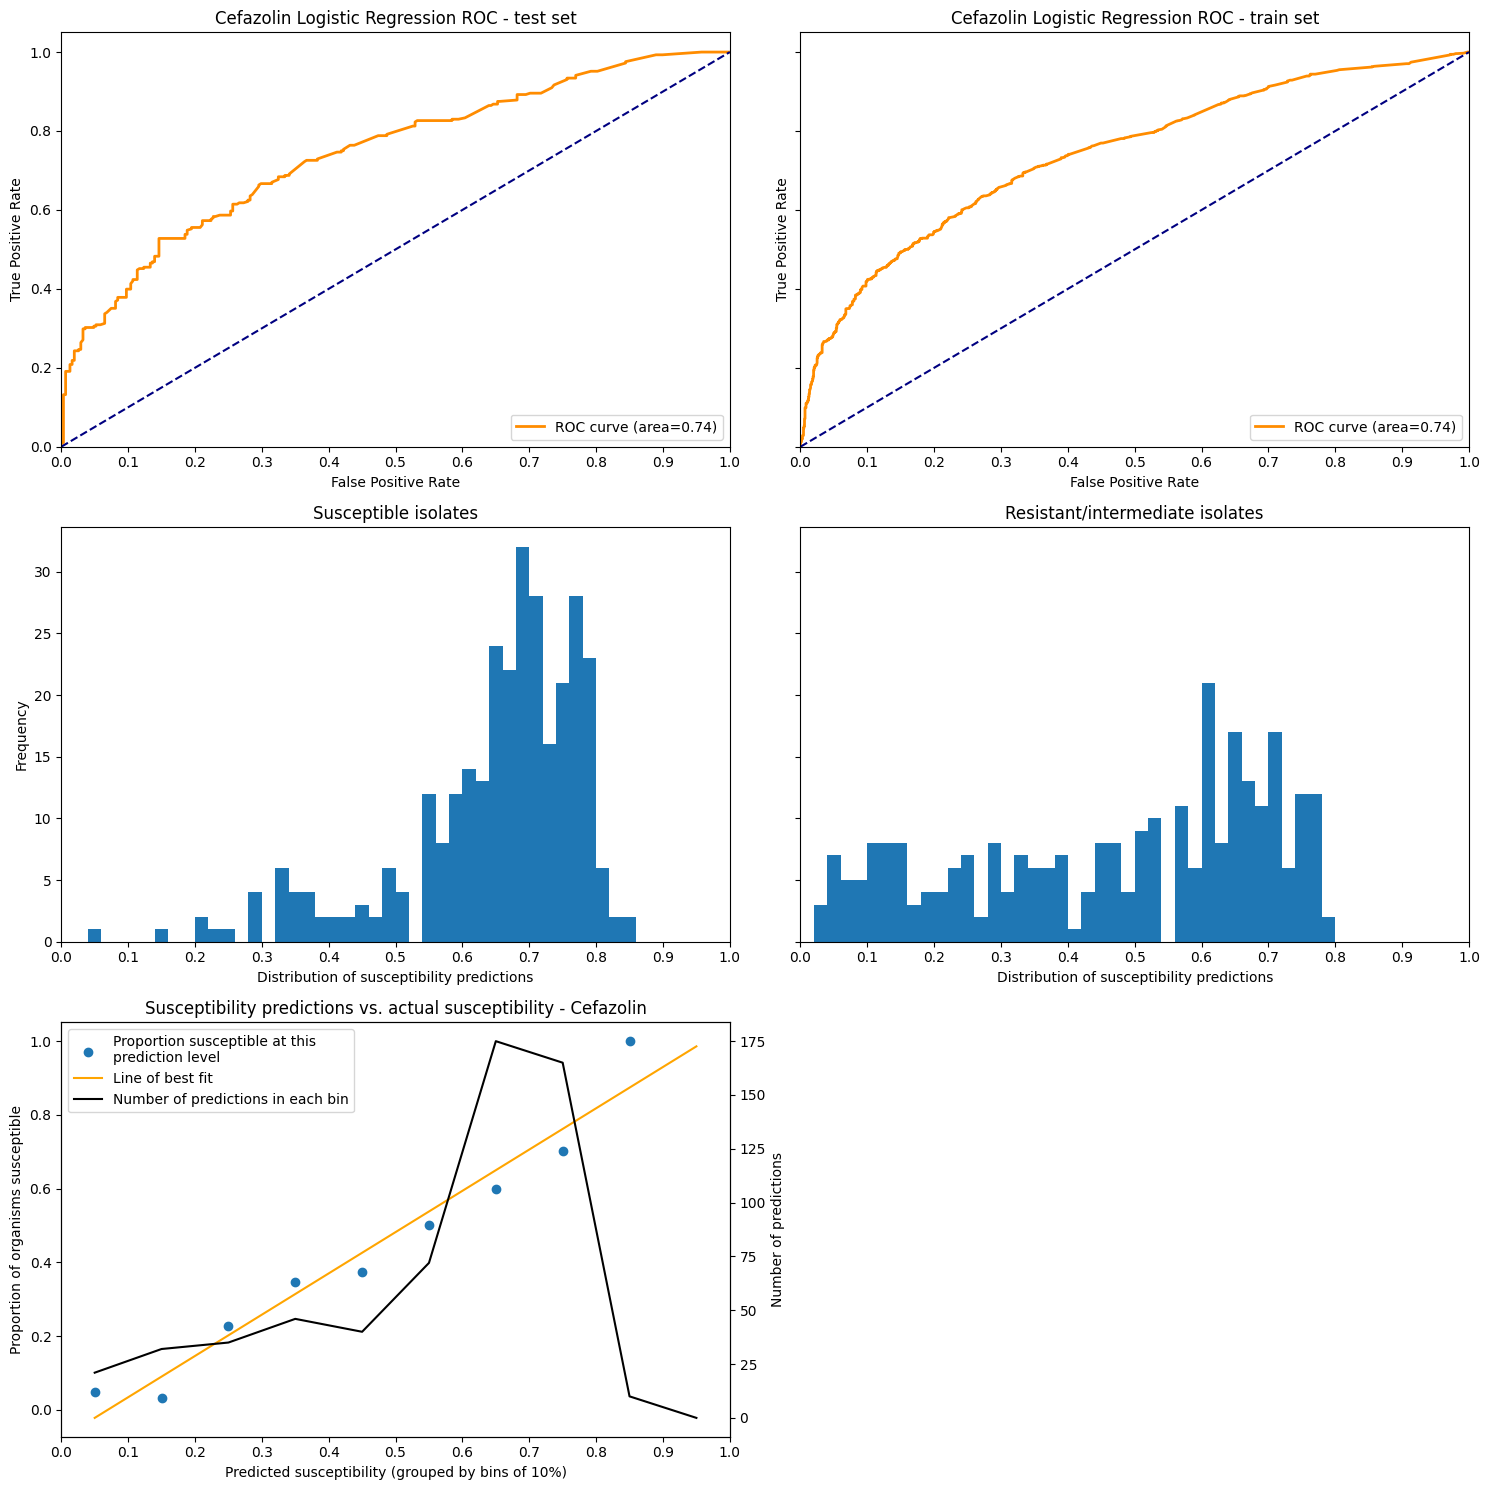


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
PriorCeftriaxoneResistance                  1.9813
ClinicalESBL                                1.1618
PriorCephalosporin                          0.6155
PriorMeropenemResistance                    0.5246
PriorOtherAbx                               0.3488
PriorCiprofloxacinResistance                0.3117
PriorAMG                                    0.2781
PriorCefazolinResistance                    0.2136
PriorTobramycinResistance                   0.1471
MedVsSurgAdmission                          0.1444
ICUExposure                                 0.1354
Hospital                                    0.0000
PriorPenicillin                            -0.0425
Age                                        -0.0605
PriorCarbapenem                            -0.0680
PriorFQ                                    -0.0932
RecentHospitalization                      -0.1146
SexCat                                     -0.1669
Prio

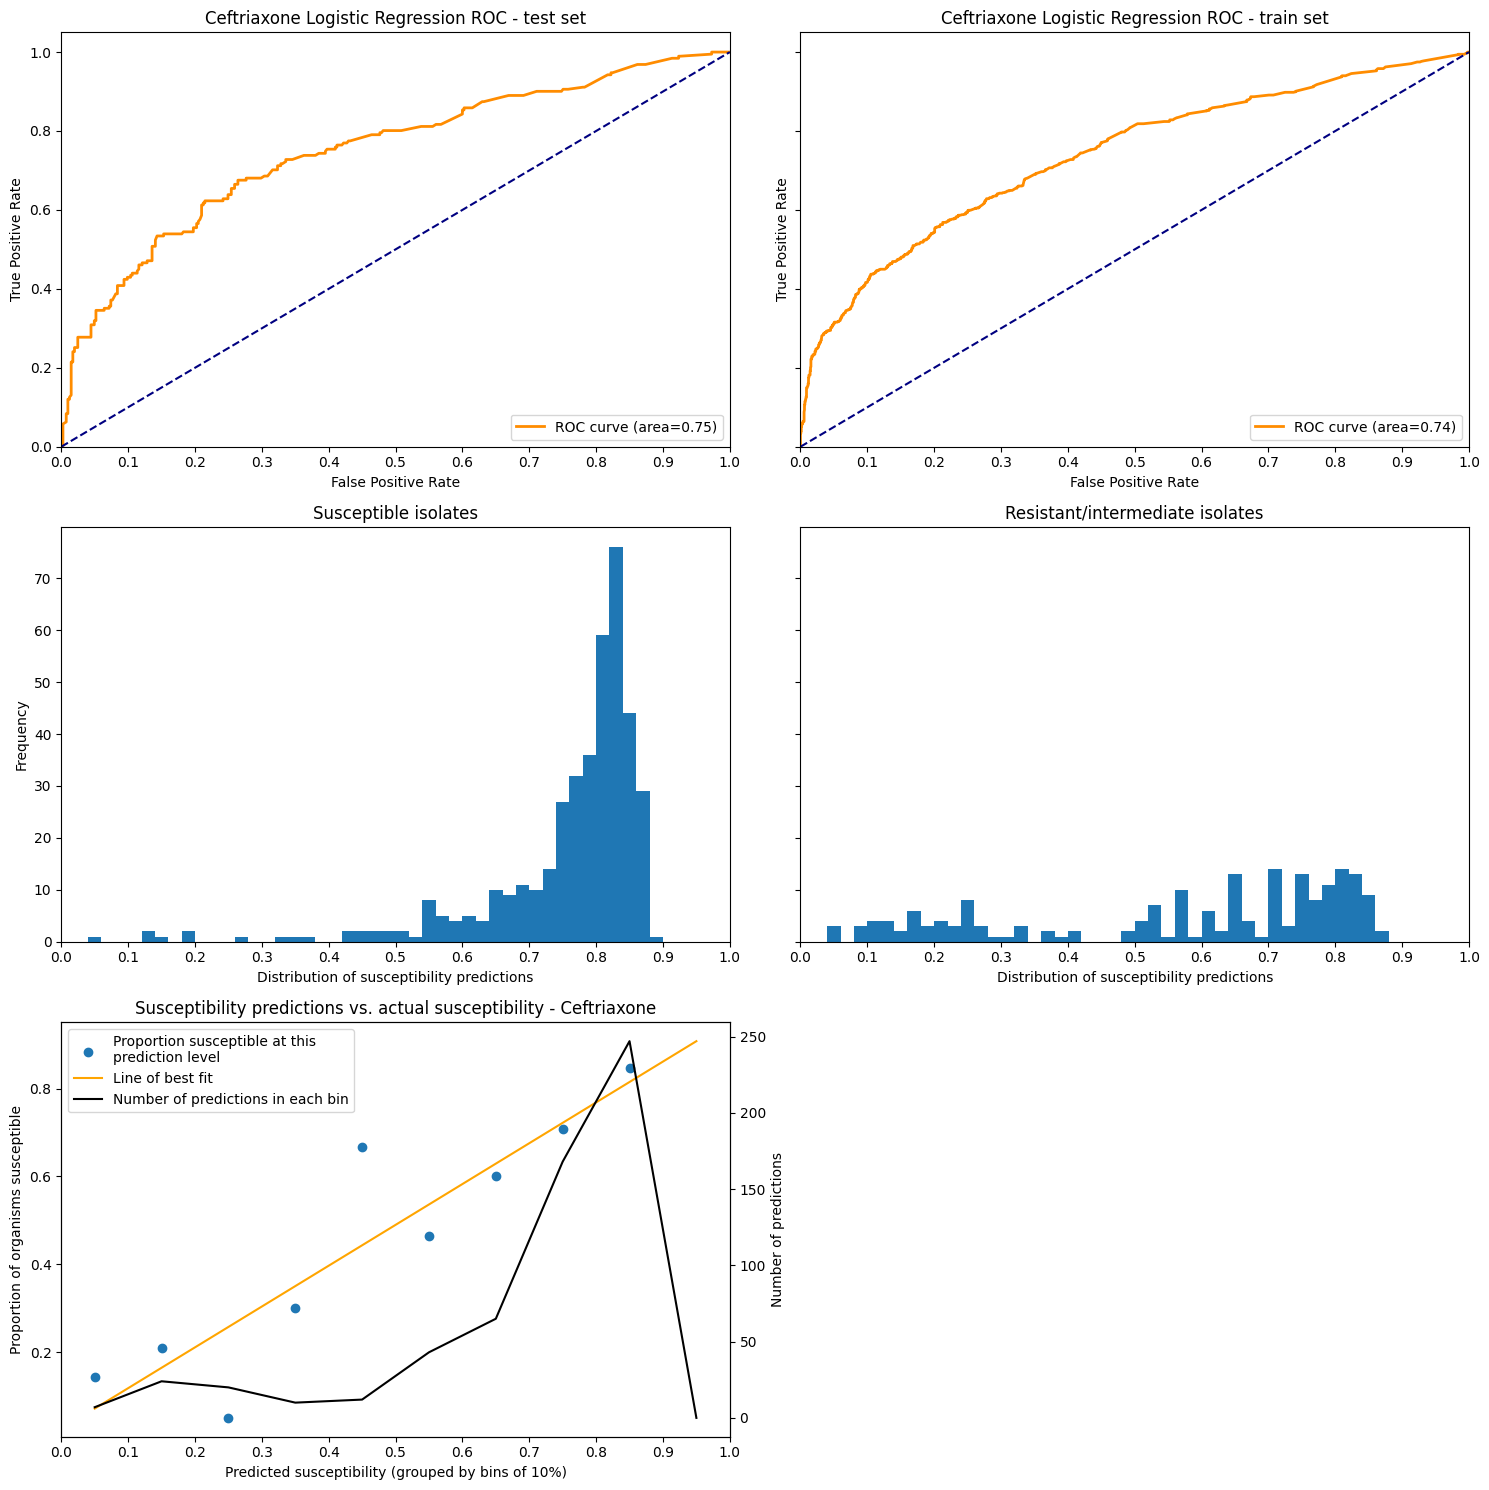


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                1.4222
PriorAMG                                    0.7256
PriorMeropenemResistance                    0.6469
PriorCeftazidimeResistance                  0.6396
PriorCeftriaxoneResistance                  0.6017
PriorTobramycinResistance                   0.4597
PriorCefazolinResistance                    0.3967
PriorOtherAbx                               0.3537
PriorCephalosporin                          0.3288
MedVsSurgAdmission                          0.1760
SexCat                                      0.1038
PriorCiprofloxacinResistance                0.1005
RecentHospitalization                       0.0250
Hospital                                    0.0000
PriorFQ                                    -0.0121
ICUExposure                                -0.0324
Age                                        -0.0426
PriorPenicillin                            -0.0644
Prio

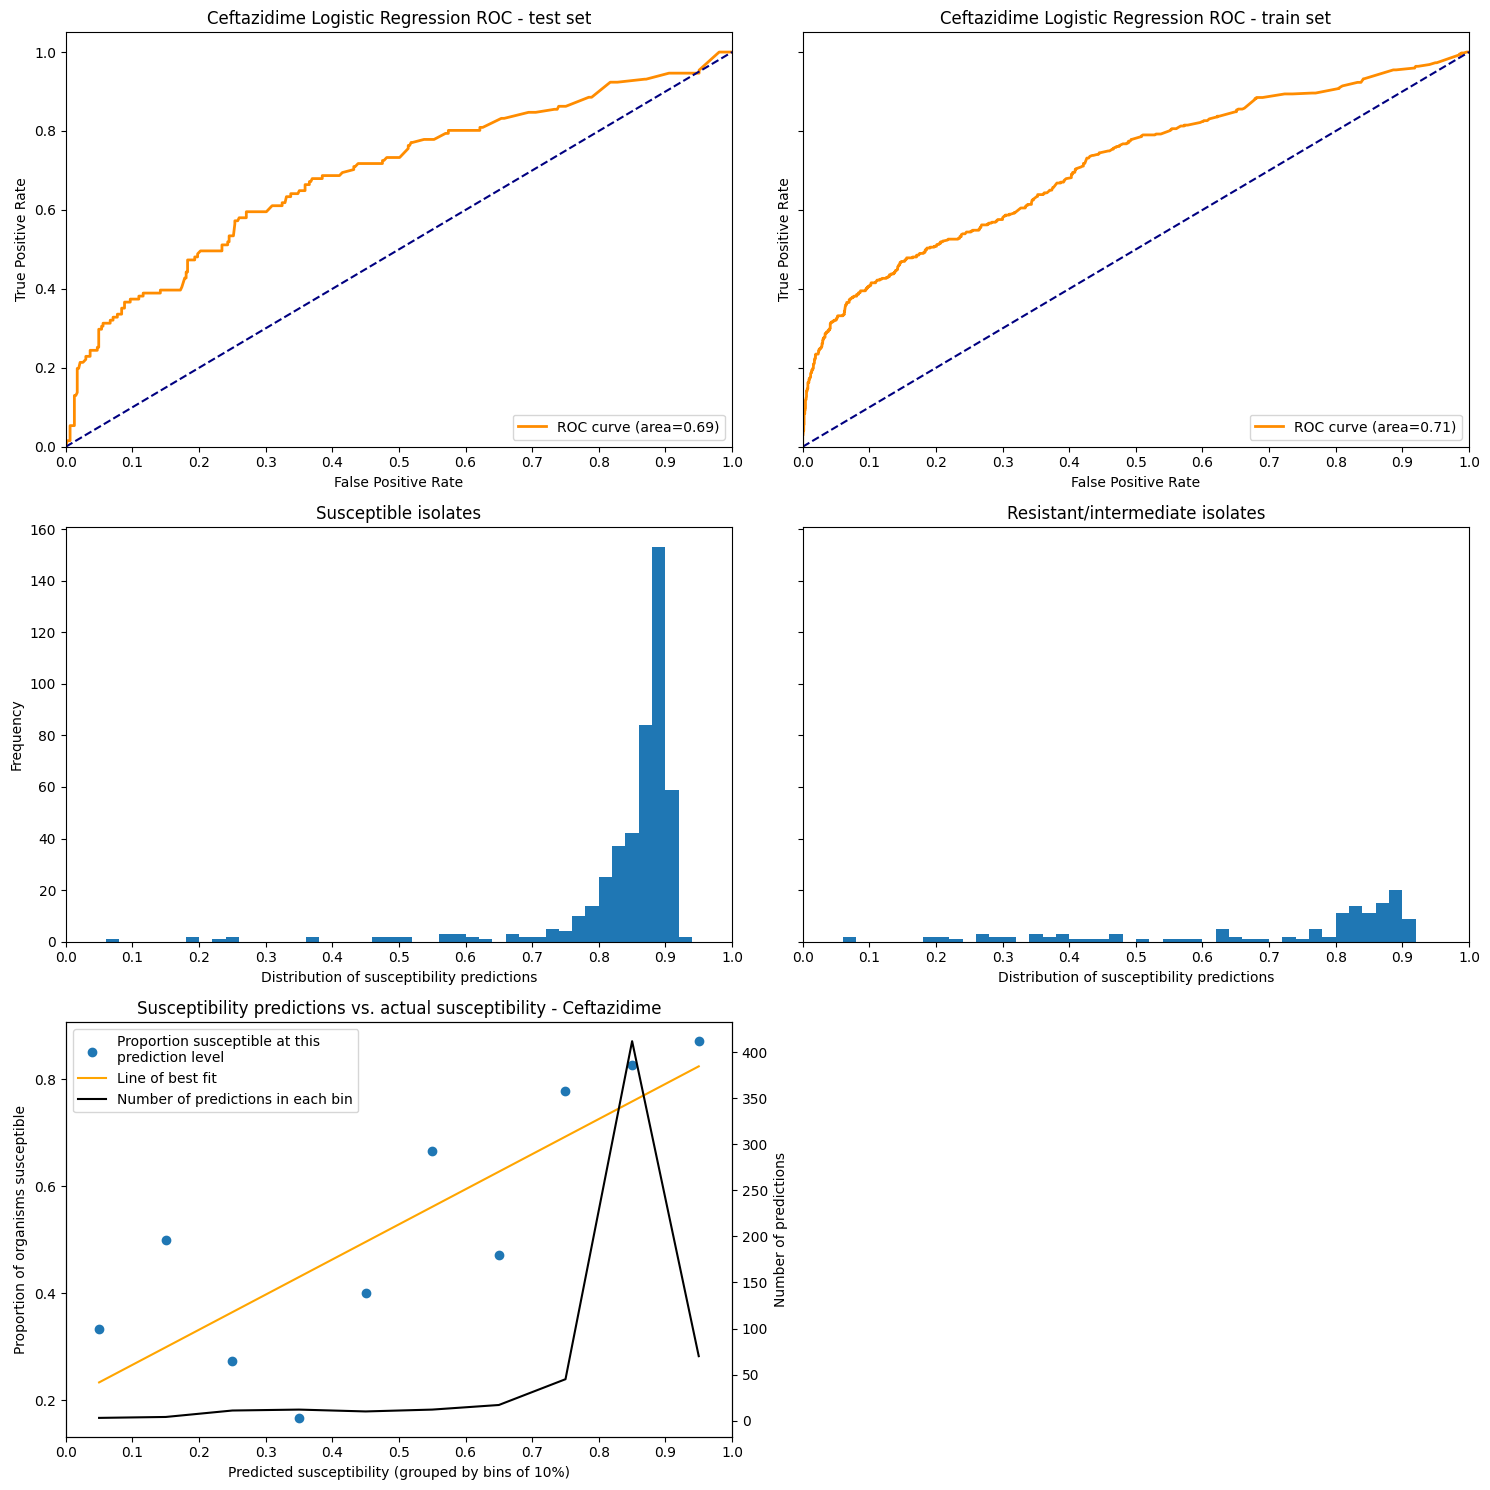


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.0554
PriorPiptazResistance                       0.7740
PriorCeftriaxoneResistance                  0.5768
PriorMeropenemResistance                    0.4848
PriorTobramycinResistance                   0.3293
PriorOtherAbx                               0.3177
PriorCephalosporin                          0.3133
PriorCiprofloxacinResistance                0.3040
PriorAMG                                    0.2302
MedVsSurgAdmission                          0.2089
PriorPenicillin                             0.2049
PriorCefazolinResistance                    0.2007
PriorCarbapenem                             0.0585
PriorFQ                                     0.0135
Hospital                                    0.0000
SexCat                                     -0.0008
Age                                        -0.0494
ICUExposure                                -0.0792
RecentHos

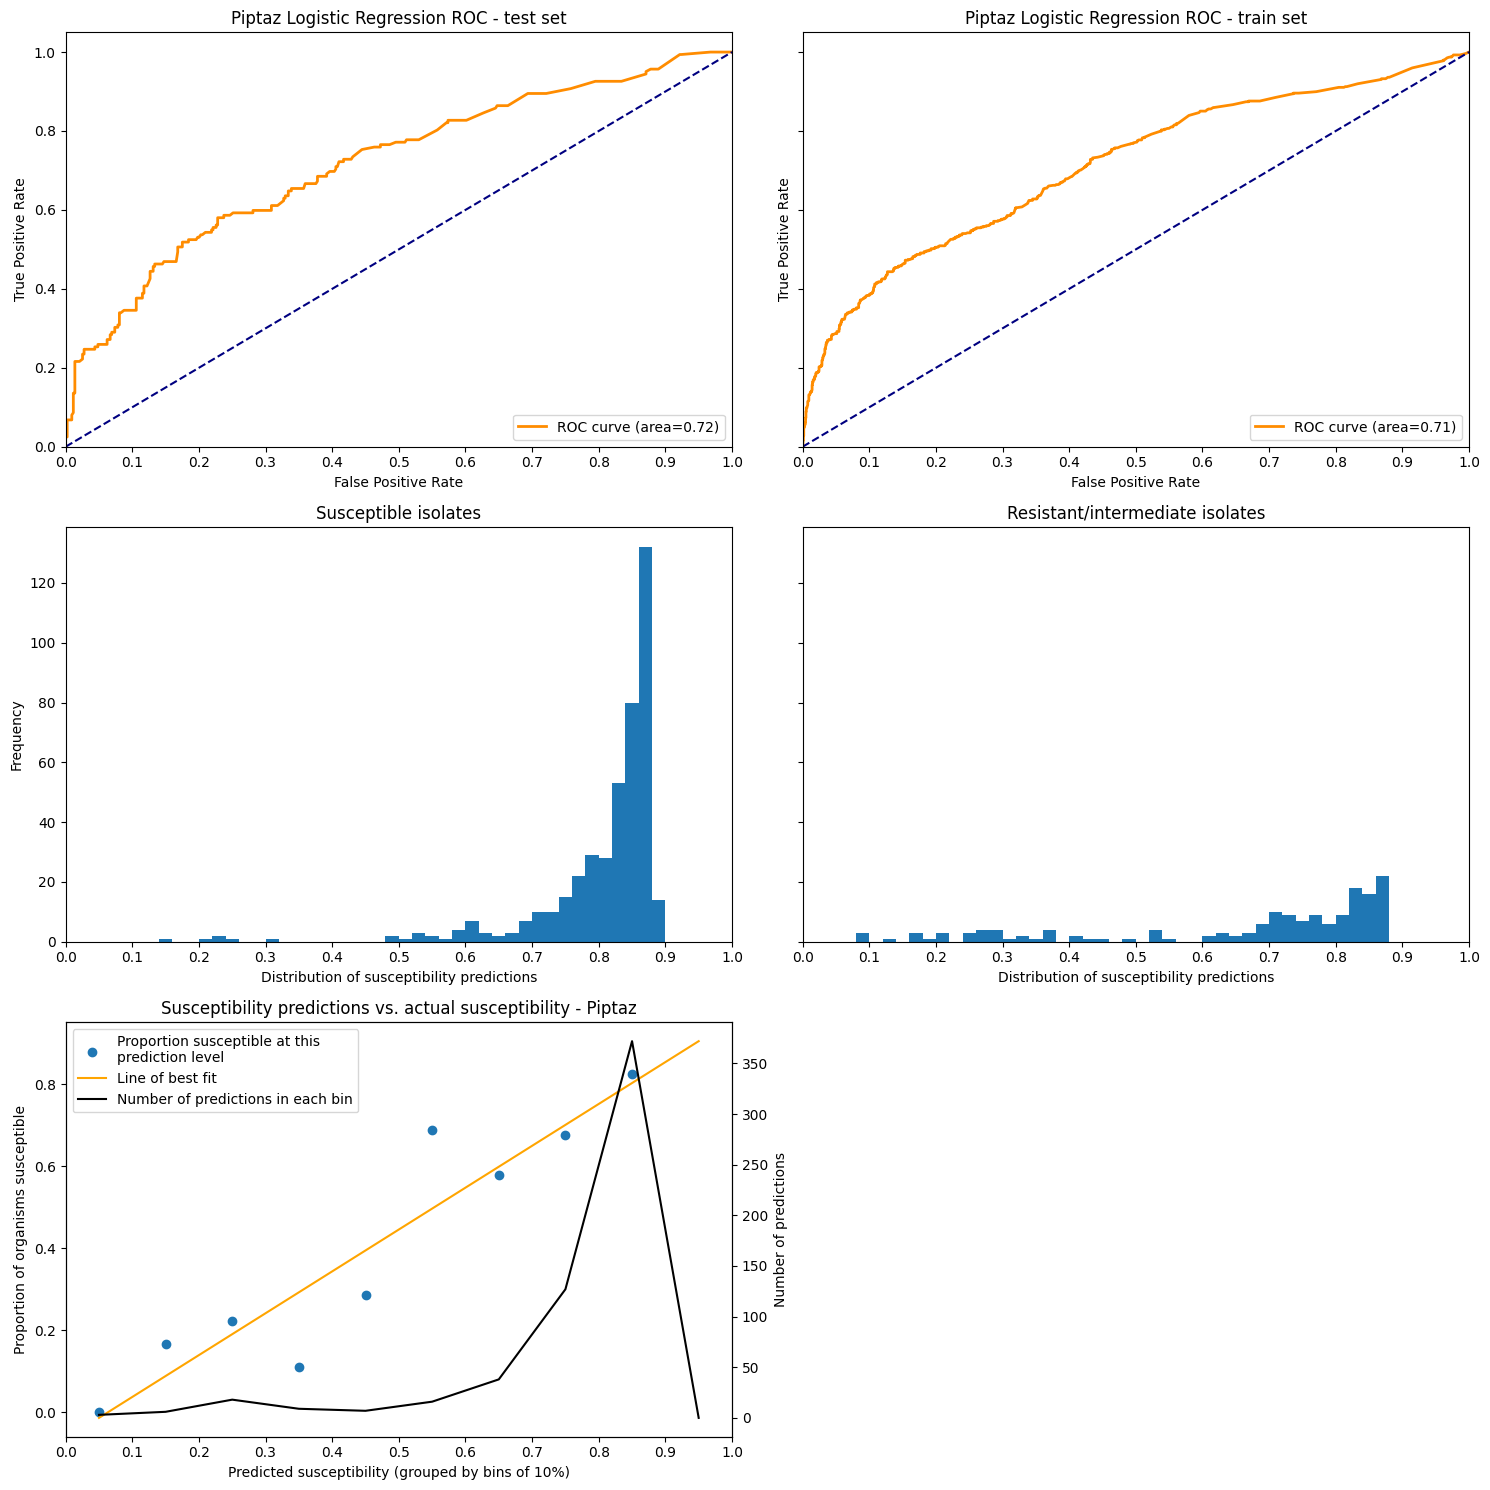


Logistic regression model for Meropenem:

Logistic Regression Coefficients
PriorCarbapenem                             1.0954
PriorCeftazidimeResistance                  1.0076
PriorMeropenemResistance                    0.9451
PriorAMG                                    0.8707
PriorCefazolinResistance                    0.5472
PriorCiprofloxacinResistance                0.4735
PriorTMPSMXResistance                       0.4157
PriorCeftriaxoneResistance                  0.3225
PriorOtherAbx                               0.2404
PriorPenicillin                             0.0915
PriorFQ                                     0.0724
ICUExposure                                 0.0712
Hospital                                    0.0000
Age                                        -0.1602
SexCat                                     -0.2584
PriorCephalosporin                         -0.2637
MedVsSurgAdmission                         -0.3364
PriorPiptazResistance                      -0.5206
Recent

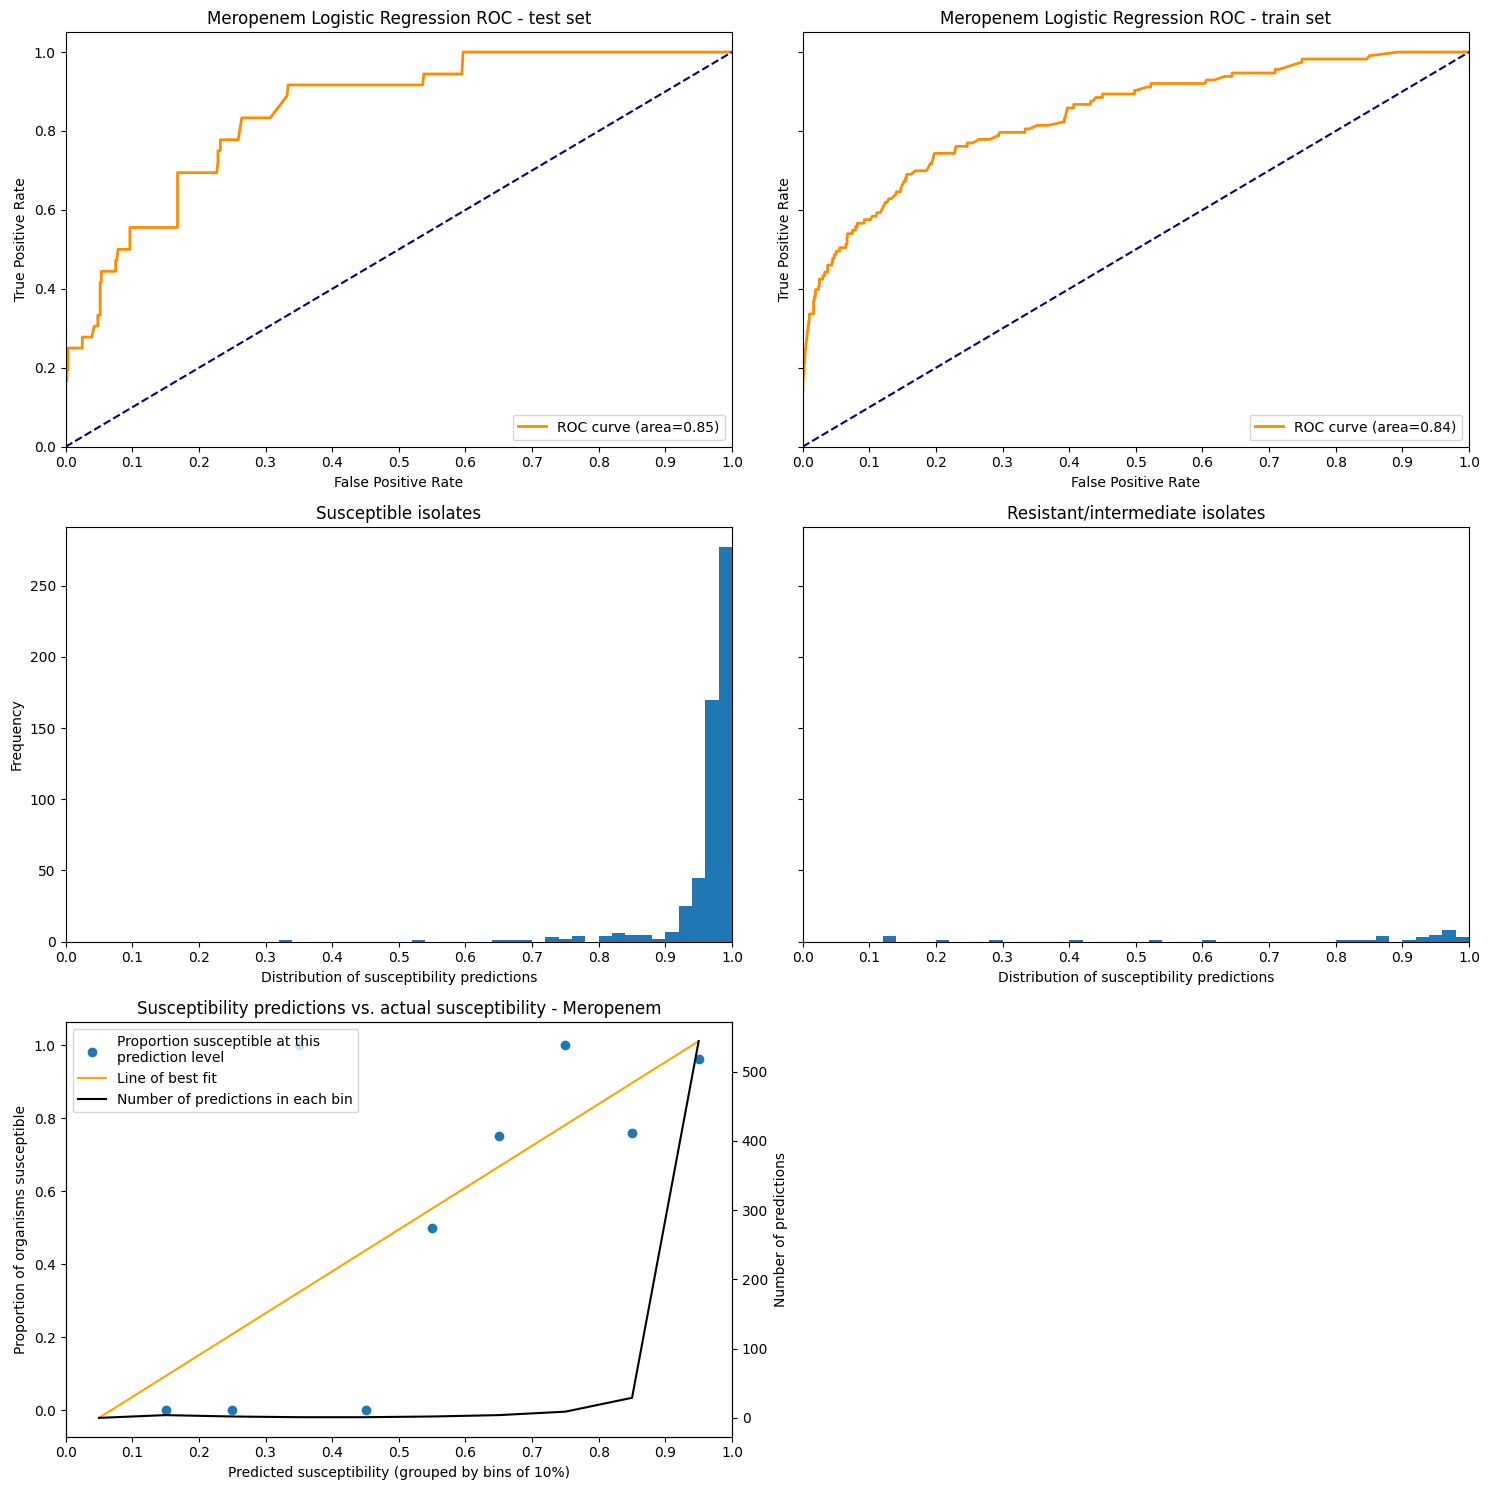


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
PriorCiprofloxacinResistance                1.8396
ClinicalESBL                                1.0635
PriorFQ                                     0.9692
PriorAMG                                    0.4365
PriorMeropenemResistance                    0.2264
PriorCefazolinResistance                    0.1203
PriorCeftriaxoneResistance                  0.0661
PriorOtherAbx                               0.0191
Hospital                                    0.0000
Age                                        -0.0185
PriorPiptazResistance                      -0.0275
RecentHospitalization                      -0.0676
PriorTMPSMXResistance                      -0.1386
MedVsSurgAdmission                         -0.1558
PriorTobramycinResistance                  -0.1843
PriorCarbapenem                            -0.1878
PriorCephalosporin                         -0.1951
PriorPenicillin                            -0.1959
Pr

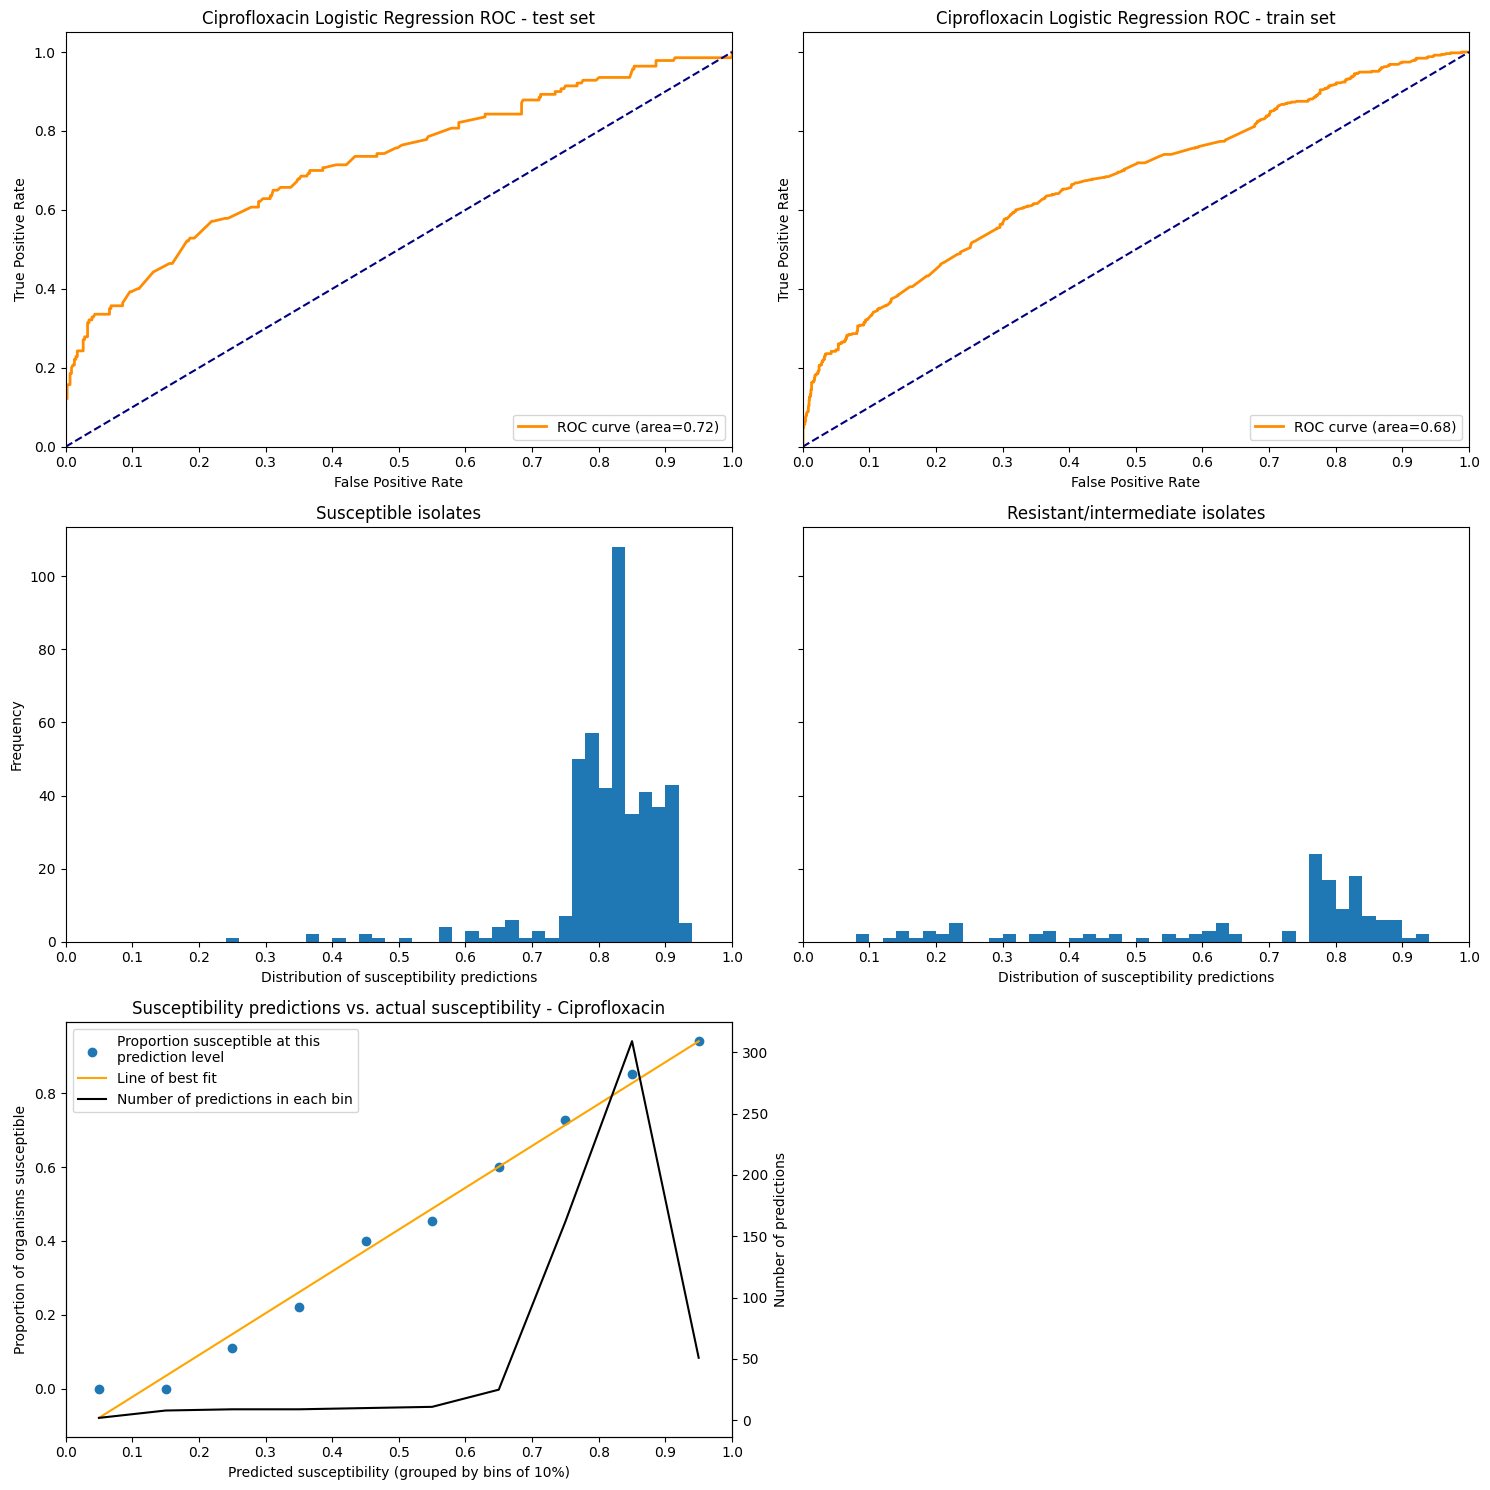


Logistic regression model for Tobramycin:

Logistic Regression Coefficients
PriorTobramycinResistance                   2.3867
ClinicalESBL                                0.6990
PriorAMG                                    0.5974
PriorCefazolinResistance                    0.4415
PriorFQ                                     0.2077
RecentHospitalization                       0.1689
PriorOtherAbx                               0.1157
PriorPiptazResistance                       0.0218
Hospital                                    0.0000
Age                                        -0.0050
ICUExposure                                -0.0200
PriorCarbapenem                            -0.0396
PriorCephalosporin                         -0.0729
PriorTMPSMXResistance                      -0.1621
PriorCeftazidimeResistance                 -0.1635
PriorMeropenemResistance                   -0.1744
MedVsSurgAdmission                         -0.2816
PriorCeftriaxoneResistance                 -0.3364
Prior

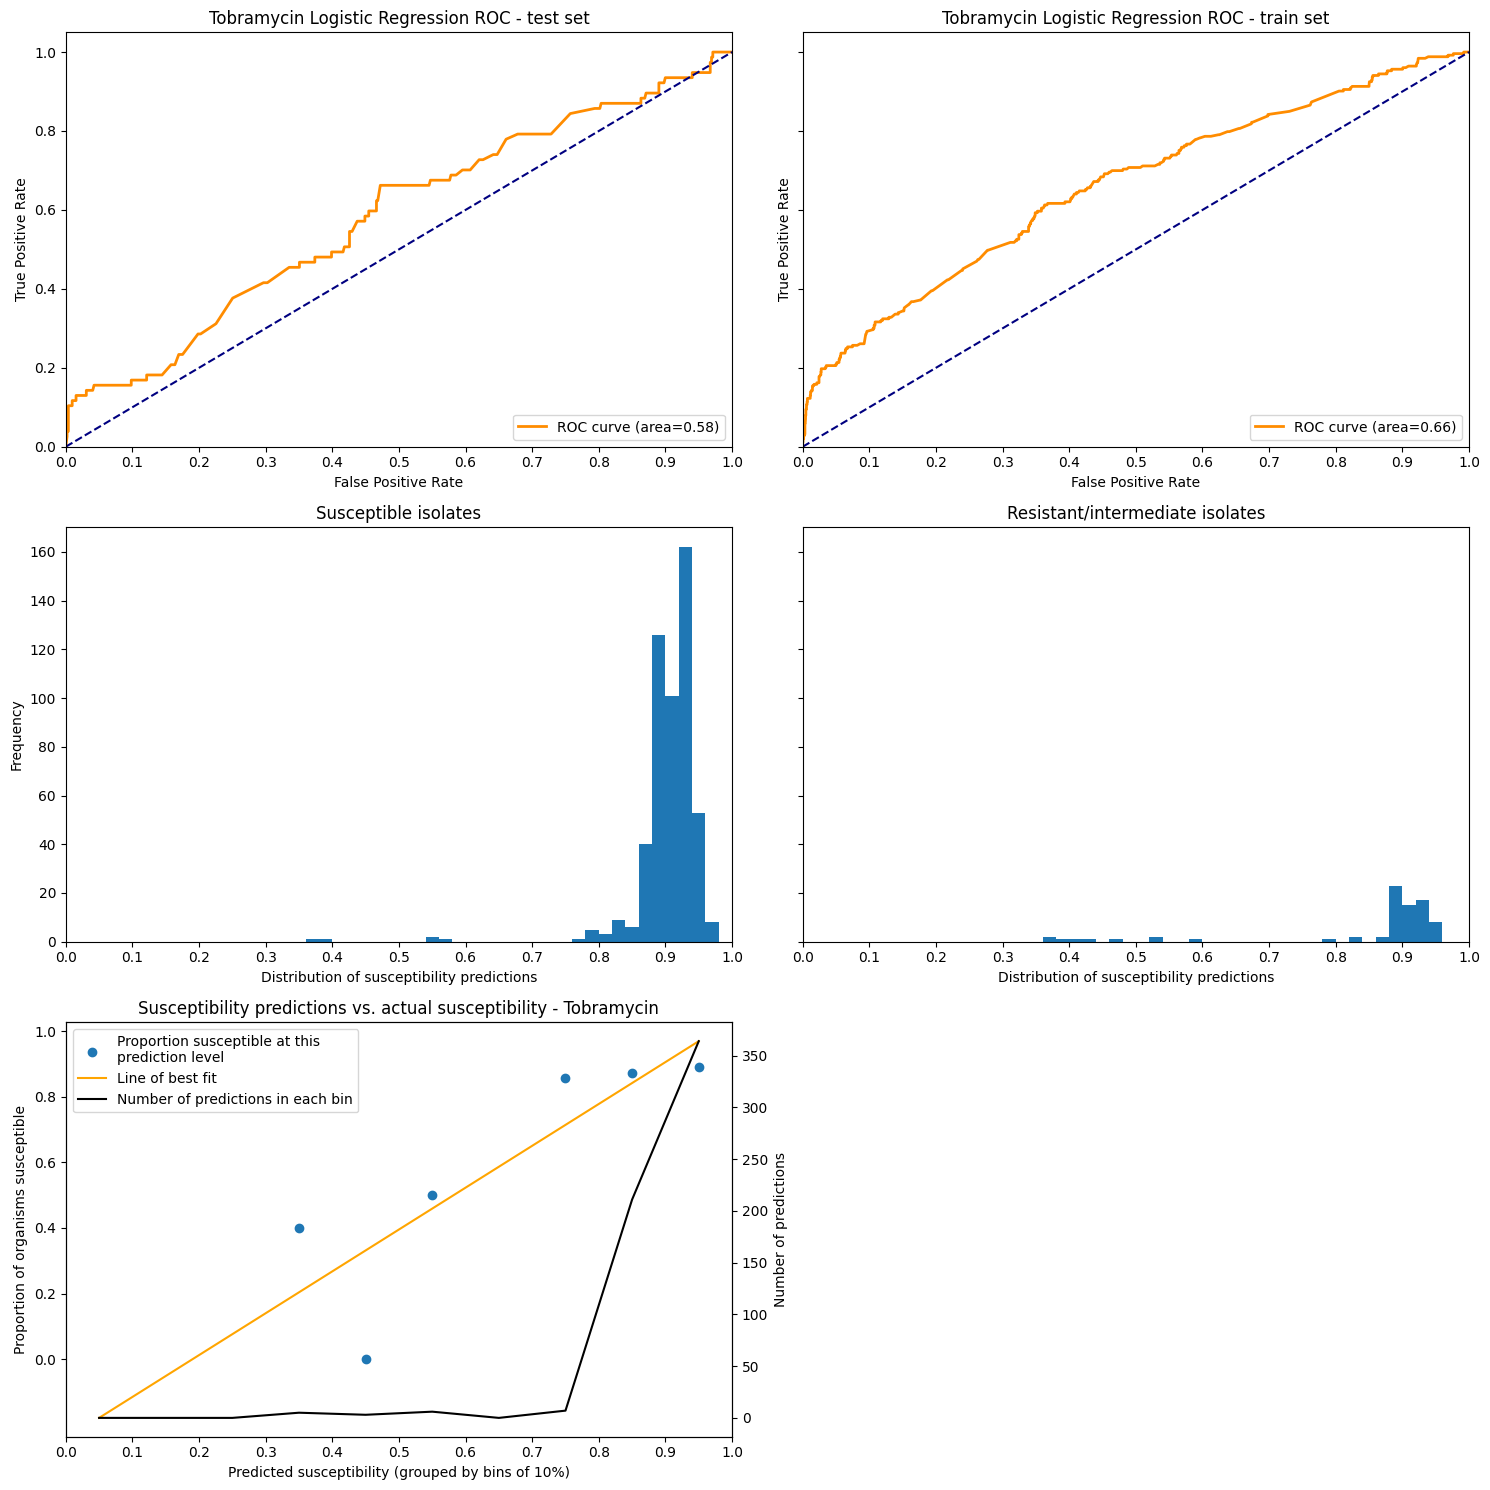


Logistic regression model for TMPSMX:

Logistic Regression Coefficients
PriorTMPSMXResistance                       1.8453
PriorCeftriaxoneResistance                  0.7466
PriorMeropenemResistance                    0.7271
ClinicalESBL                                0.6187
PriorTobramycinResistance                   0.4446
PriorOtherAbx                               0.2569
PriorCephalosporin                          0.1956
MedVsSurgAdmission                          0.1924
PriorFQ                                     0.1377
Hospital                                    0.0000
PriorCiprofloxacinResistance               -0.0052
PriorCarbapenem                            -0.0581
PriorCeftazidimeResistance                 -0.0589
Age                                        -0.0619
RecentHospitalization                      -0.0632
PriorAMG                                   -0.0938
SexCat                                     -0.1050
PriorPenicillin                            -0.1246
ICUExposu

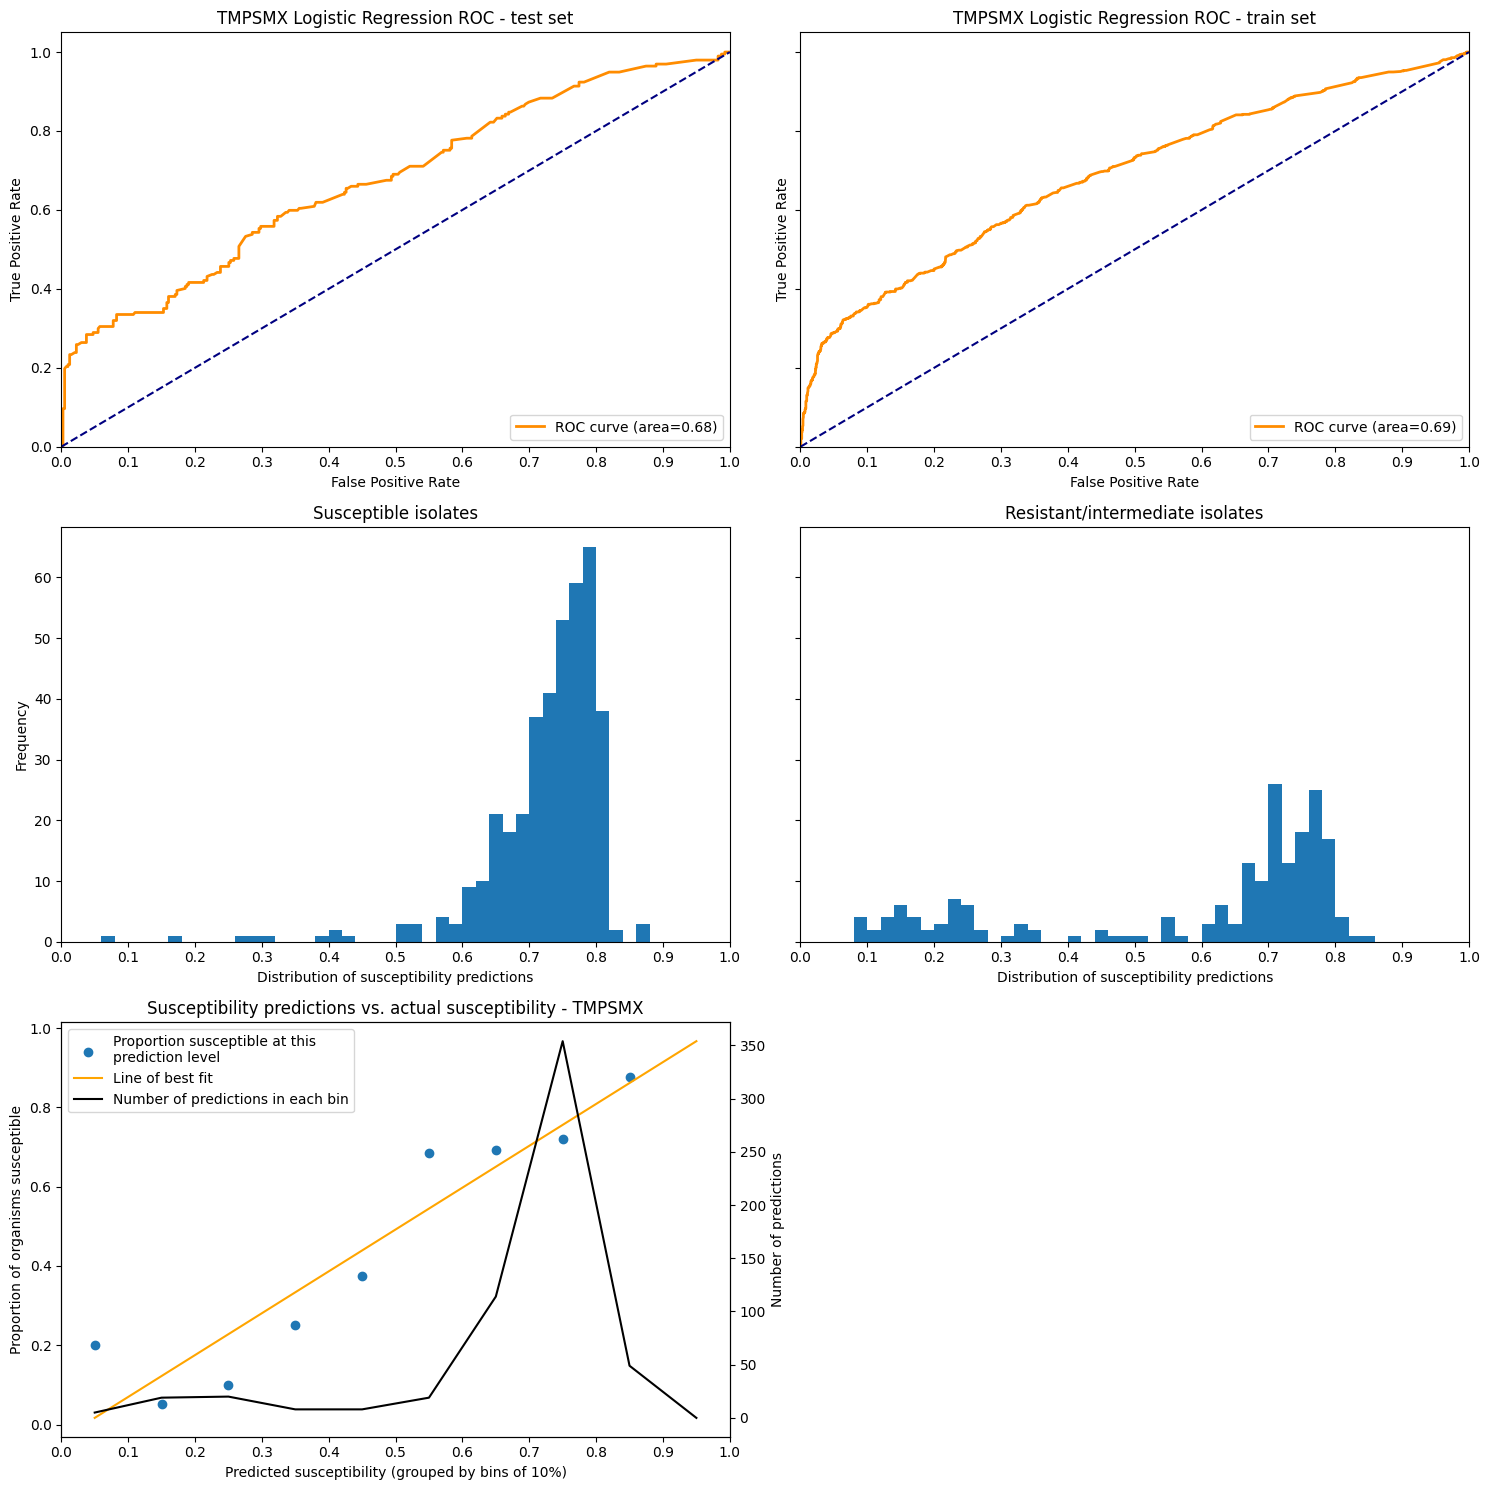


Logistic regression model for Piptaz_or_Tobramycin:

Logistic Regression Coefficients
PriorTobramycinResistance                   1.7438
ClinicalESBL                                0.7336
PriorPiptazResistance                       0.5867
PriorCefazolinResistance                    0.4032
RecentHospitalization                       0.2434
PriorFQ                                     0.2294
PriorCarbapenem                             0.1493
PriorOtherAbx                               0.0406
Hospital                                    0.0000
PriorCephalosporin                         -0.0056
PriorCeftazidimeResistance                 -0.0114
ICUExposure                                -0.0449
PriorAMG                                   -0.0536
Age                                        -0.0555
PriorMeropenemResistance                   -0.0820
PriorPenicillin                            -0.0917
MedVsSurgAdmission                         -0.1616
PriorCeftriaxoneResistance                 -0.

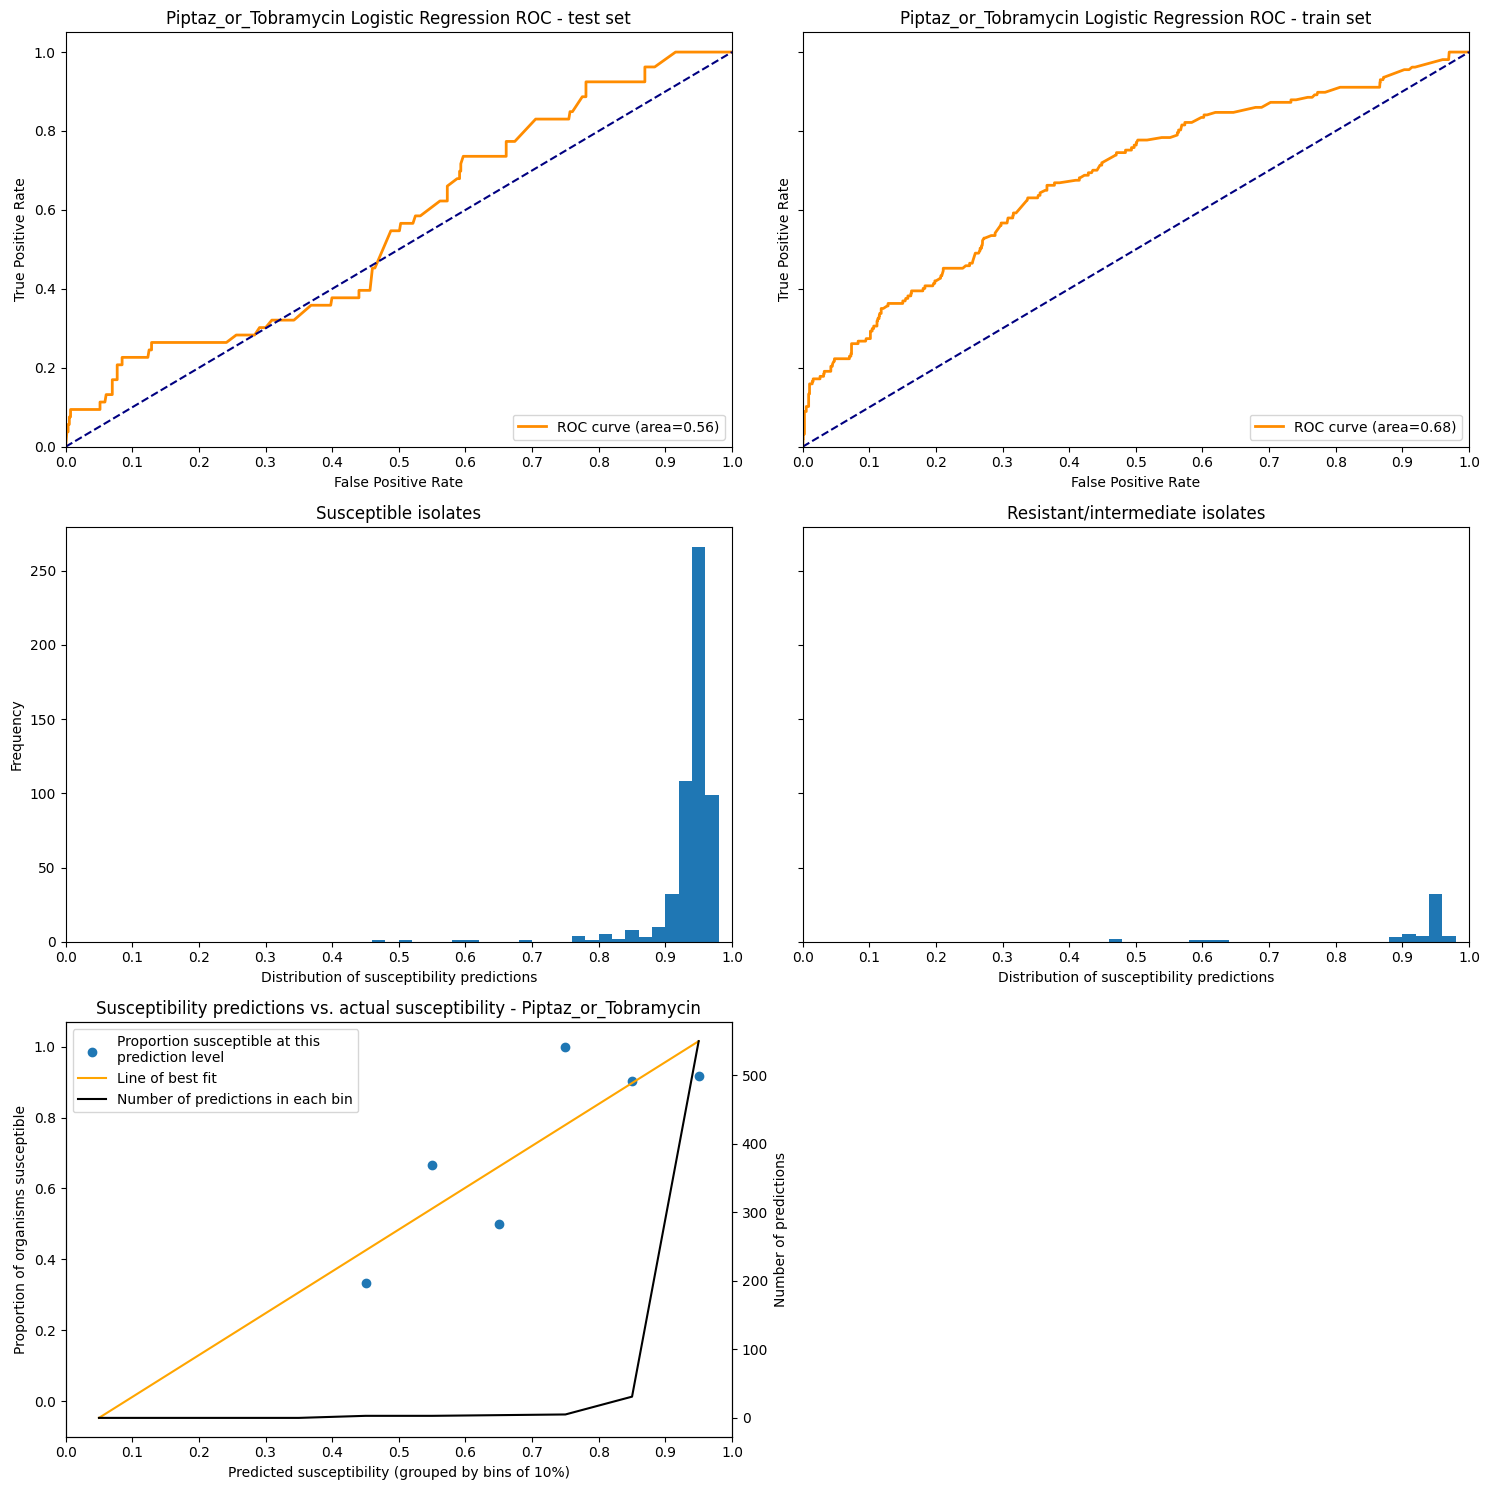

In [9]:
# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(X_train,Y_train)
    
    # Save the regression model to pickle
    with open(antibiotic+'.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)
        
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))

    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            

    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates,
             bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates,
             bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    


    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

In [10]:
# Mean predicted susceptibility of each antibiotic
print('Mean predicted susceptibility of each analyzed antibiotic\n')
print('{:<20} {:<7} {:<7}'.format('Antibiotic','Prob S','Actual S'))

for antibiotic in antibiotic_list:
        
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(X_train,Y_train)
    
    # print(antibiotic, 1-np.mean(Y_test))
    print('{:<20} {:>6.2f} {:>9.2f}'.format(antibiotic, 
                                            np.mean(reg.predict_proba(X_test)[:,0]),
                                            1-np.mean(Y_test)))

Mean predicted susceptibility of each analyzed antibiotic

Antibiotic           Prob S  Actual S
Cefazolin              0.56      0.52
Ceftriaxone            0.70      0.68
Ceftazidime            0.81      0.78
Piptaz                 0.77      0.73
Meropenem              0.95      0.94
Ciprofloxacin          0.78      0.77
Tobramycin             0.90      0.87
TMPSMX                 0.68      0.67
Piptaz_or_Tobramycin   0.93      0.91
